<a href="https://colab.research.google.com/github/AFirooz/bayesian-network-analysis-tools/blob/main/Creating_a_Bayesian_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Lib

In [8]:
!apt-get install -yq graphviz graphviz-dev

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [9]:
# -U: upgrade all
# -q: quite install
!pip install -Uq pgmpy graphviz pygraphviz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Part 1: Importing Example BN

## Asia Model

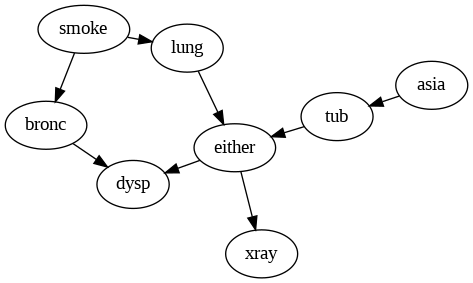

In [10]:
from IPython.display import Image
from pgmpy.utils import get_example_model

# Load the model
asia_model = get_example_model('asia')

# Visualize the network
viz = asia_model.to_graphviz()
viz.draw('asia.png', prog='neato')
Image('asia.png')

## Earthquake Model

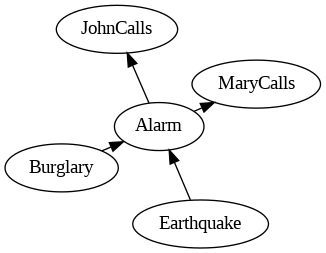

In [11]:
# Load the model
earth_model = get_example_model('earthquake')

# Visualize the network
viz = earth_model.to_graphviz()
viz.draw('earth.png', prog='neato')
Image('earth.png')

# Exploring the Asia Model

In [18]:
import pprint

# Access attributes of the model
nodes = asia_model.nodes()
edges = asia_model.edges()
cpds = asia_model.get_cpds()

print(f"Nodes in the model: {nodes} \n")
print(f"Edges in the model: {edges} \n")
print(f"CPDs in the model: ")

for cpd in cpds:
  print(str(cpd))

Nodes in the model: ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp'] 

Edges in the model: [('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')] 

CPDs in the model: 
+-----------+------+
| asia(yes) | 0.01 |
+-----------+------+
| asia(no)  | 0.99 |
+-----------+------+
+------------+------------+-----------+
| smoke      | smoke(yes) | smoke(no) |
+------------+------------+-----------+
| bronc(yes) | 0.6        | 0.3       |
+------------+------------+-----------+
| bronc(no)  | 0.4        | 0.7       |
+------------+------------+-----------+
+-----------+-------------+------------+-------------+------------+
| bronc     | bronc(yes)  | bronc(yes) | bronc(no)   | bronc(no)  |
+-----------+-------------+------------+-------------+------------+
| either    | either(yes) | either(no) | either(yes) | either(no) |
+-----------+-------------+------------+-------------+--

# Part 2: Defining a Model Manually (Discrete Variables)

Defining a network in pgmpy involves two steps: 1. Define the network structure 2. Define the parameterization, i.e. CPDs

We'll use the Cancer network as an example that we'll reconstruct.


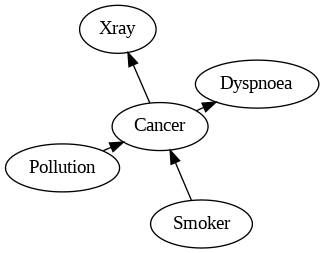

In [23]:
# Load the model
cancer_model_ = get_example_model('cancer')

# Visualize the network
viz = cancer_model_.to_graphviz()
viz.draw('cancer.png', prog='neato')
Image('cancer.png')

## 1. Network Structure

In [35]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD


# The network structure
cancer_model = DiscreteBayesianNetwork(
    [
        ("Pollution", "Cancer"),
        ("Smoker", "Cancer"),
        ("Cancer", "Xray"),
        ("Cancer", "Dyspnoea"),
    ]
)

cancer_model.nodes()

NodeView(('Pollution', 'Cancer', 'Smoker', 'Xray', 'Dyspnoea'))

## 2. Conditional Probability Distributions (CPD) or Tables (CPT)


1. `variable_card` denotes how many categories the variable can take
2. `state_names` is optional, it gives names for each outcome. If one node is defined, must define in all related nodes.
3. `evidence` denotes the nodes that affects probability of the defined node
4. `evidence_card` denotes cardinality of each evidence variable. There are total 2*3=6 different combinations of evidence.
5. `values` pass the probabilities for each outcome. Must sum up to 1 columnwise.

To understand how the `values` are arranged, see example below. Note that for example the first coloumn refers to `A(0)B(0)C(0)`, then `A(0)B(0)C(1)`, and `A(0)B(1)C(0)`, `A(0)B(1)C(1)`, etc. It is as though we loop over A, and B, and C, in a nested order.

In [27]:
cpd_example = TabularCPD(
    variable="D",
    variable_card=2,
    values=[[0.20, 0.15, 0.93, 0.05, 0.001, 0.02, 0.10, 0.25 ],
            [0.80, 0.85, 0.07, 0.95, 0.999, 0.98, 0.90, 0.75 ]],
    evidence=["A", "B", "C"],
    evidence_card=[2, 2, 2],
)

print(cpd_example)


+------+------+------+------+------+-------+------+------+------+
| A    | A(0) | A(0) | A(0) | A(0) | A(1)  | A(1) | A(1) | A(1) |
+------+------+------+------+------+-------+------+------+------+
| B    | B(0) | B(0) | B(1) | B(1) | B(0)  | B(0) | B(1) | B(1) |
+------+------+------+------+------+-------+------+------+------+
| C    | C(0) | C(1) | C(0) | C(1) | C(0)  | C(1) | C(0) | C(1) |
+------+------+------+------+------+-------+------+------+------+
| D(0) | 0.2  | 0.15 | 0.93 | 0.05 | 0.001 | 0.02 | 0.1  | 0.25 |
+------+------+------+------+------+-------+------+------+------+
| D(1) | 0.8  | 0.85 | 0.07 | 0.95 | 0.999 | 0.98 | 0.9  | 0.75 |
+------+------+------+------+------+-------+------+------+------+


In [38]:
# defining the states for later use. Remember it's optional
state_poll = {'Pollution': ['Clean', 'Bad', 'Fatal']}
state_smoke = {'Smoker': ['Non-smoker', 'Smoker']}
state_cancer = {'Cancer': ['No Cancer', 'Cancer']}
state_xray = {'Xray': ['Positive', 'Negative']}
state_dysp = {'Dyspnoea': ['Positive', 'Negative']}


In [41]:
# Define the CPTs
cpd_poll = TabularCPD(
    variable="Pollution",
    variable_card=3,
    values=[[0.7], [0.29], [0.01]],
    state_names = state_poll
    )

cpd_smoke = TabularCPD(
    variable="Smoker",
    variable_card=2,
    values=[[0.3], [0.7]],
    state_names = state_smoke
    )

cpd_cancer = TabularCPD(
    variable="Cancer",
    variable_card=2,
    values=[[0.20, 0.15, 0.03, 0.05, 0.001, 0.02],
            [0.80, 0.85, 0.97, 0.95, 0.999, 0.98]],
    evidence=["Smoker", "Pollution"],
    evidence_card=[2, 3],
    state_names={**state_cancer, **state_smoke, **state_poll}
)

cpd_xray = TabularCPD(
    variable="Xray",
    variable_card=2,
    values=[[0.9, 0.2], [0.1, 0.8]],
    evidence=["Cancer"],
    evidence_card=[2],
    state_names={**state_xray, **state_cancer}
)

cpd_dysp = TabularCPD(
    variable="Dyspnoea",
    variable_card=2,
    values=[[0.65, 0.3], [0.35, 0.7]],
    evidence=["Cancer"],
    evidence_card=[2],
    state_names={**state_dysp, **state_cancer}
)

# Add the CPDs to the model
cancer_model.add_cpds(cpd_poll, cpd_smoke, cpd_cancer, cpd_xray, cpd_dysp)

# Verify the model is correctly defined
cancer_model.check_model()


True

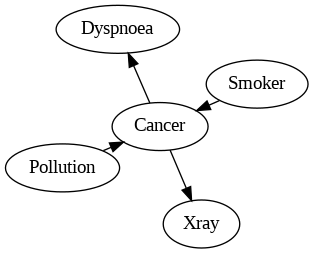

In [42]:
# Visualize the network
viz = cancer_model.to_graphviz()
viz.draw('cancer.png', prog='neato')
Image('cancer.png')

# Part 2.5: Defining a Model Manually (Continuous Variables)


In [59]:
from pgmpy.models import LinearGaussianBayesianNetwork


people_model = LinearGaussianBayesianNetwork([
    ("Healthy", "Happy"),
    ("Wealthy", "Happy"),
])

In [60]:
# Step 2: Define the CPDs.
import pprint
from pgmpy.factors.continuous import LinearGaussianCPD


cpd_healthy = LinearGaussianCPD(variable="Healthy", beta=[4], std=2, evidence=[])
cpd_wealthy = LinearGaussianCPD(variable="Wealthy", beta=[2], std=3, evidence=[])

pprint.pp(cpd_healthy)
pprint.pp(cpd_wealthy)

<LinearGaussianCPD: P(Healthy) = N(4; 2) at 0x7c2858663950
<LinearGaussianCPD: P(Wealthy) = N(2; 3) at 0x7c2858661950


The `Happy` variable has mean `3*Healthy + 2*Wealthy + 1`, this formula is determined by passing beta and evidence variables.

Note that the **first element** of beta is the **intercept** (constant term). The rest of the elements in beta each match the evidence.

In [61]:
cpd_happy = LinearGaussianCPD(
    variable="Happy",
    beta=[1, 3, 2],
    std=5,
    evidence=["Healthy", "Wealthy"],
)

pprint.pp(cpd_happy)

<LinearGaussianCPD: P(Happy | Healthy, Wealthy) = N(3*Healthy + 2*Wealthy + 1; 5) at 0x7c2858661010


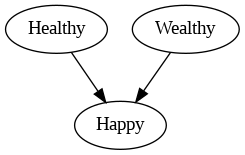

In [62]:
people_model.add_cpds(cpd_healthy, cpd_wealthy, cpd_happy)

if people_model.check_model():
    viz = people_model.to_graphviz()
    viz.draw('people.png', prog='dot')

Image('people.png')